In [9]:
import salem as sa
import xarray as xr
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pyproj import Proj
import numpy as np
import pandas as pd

In [10]:
data_base_folder = Path('/home/ben/data/GAR/')
project = 'rc_trop_ls_MM/temp/'

In [11]:
color_map = LinearSegmentedColormap.from_list(
    "mycmap",
    ["white", "steelblue", "c", "khaki", "orange", "orangered", "r", "darkred"],
)

def plot_map(ax, ds, model, cmap, scalebar=False):
    smap = ds.salem.get_map(data=model, cmap=cmap, vmin=0, vmax=1020)
    x, y = smap.grid.transform(lons, lats)
    smap.set_shapefile(countries=False)
    smap.set_lonlat_contours(xinterval=1)
    if scalebar:
        smap.set_scale_bar(location=(0.85, 0.08))
    smap.visualize(addcbar=False)
    return smap

In [12]:
grid = sa.mercator_grid(center_ll=(-90, 0), extent=(100000, 100000))
oceans = sa.read_shapefile(sa.get_demo_file('ne_50m_ocean.shp'),
                              cached=True)
grid

<salem.Grid>
  proj: +datum=WGS84 +k=0.9996 +lat_0=0 +lon_0=-90 +no_defs+proj=tmerc +units=m +x_0=0 +y_0=0
  pixel_ref: corner
  origin: lower-left
  (nx, ny): (600, 600)
  (dx, dy): (166.66666666666666, 166.66666666666666)
  (x0, y0): (-50000.0, -50000.0)

In [13]:
def remove_nonalphanumerics(string: str) -> str:
    return "".join(ch for ch in string if ch.isalnum())

def open_dataset(file, ):
    data_base_folder = Path('/home/ben/data/GAR/')
    ds = xr.open_dataset(
        data_base_folder / file,
        decode_cf=False
    )
    projection = {
        "lat_0": float(ds.attrs["PROJ_ENVI_STRING"].split(",")[3]),
        "lon_0": float(ds.attrs["PROJ_ENVI_STRING"].split(",")[4]),
        "x_0": float(ds.attrs["PROJ_ENVI_STRING"].split(",")[5]),
        "y_0": float(ds.attrs["PROJ_ENVI_STRING"].split(",")[5]),
        "ellps": remove_nonalphanumerics(ds.attrs["PROJ_ENVI_STRING"].split(",")[7]),
        "name": remove_nonalphanumerics(
            str(ds.attrs["PROJ_ENVI_STRING"].split(",")[8])
        ),
    }
    # pyproj_srs='+proj=merc +lat_0=2 +lon_0=-89.5 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
    proj = "merc" if projection["name"].lower() == "wrfmercator" else "lcc"
    pyproj_srs = (
        f"+proj={proj} +lat_0={str(projection['lat_0'])} +lon_0={str(projection['lon_0'])} +k=1 "
        f"+x_0={str(projection['x_0'])} +y_0={str(projection['y_0'])} +ellps={projection['ellps']} "
        f"+datum={projection['ellps']} +units=m +no_defs"
    )

    split = file.split('/')[-1].split('_')
    var = split[-2]
    if var == 'lu':
        var = split[-2] + '_' + split[-1].split('.')[0]
    ds[var].attrs['pyproj_srs'] = pyproj_srs
    return ds

In [15]:
proj_string = '+proj=merc +lat_0=2 +lon_0=-90.32 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'

In [16]:
def find_lonlat(ds, var, lon, lat):
    abslat = np.abs(ds.lat-lat)
    abslon = np.abs(ds.lon-lon)
    c = np.maximum(abslon, abslat)
    ([xlon], [xlat]) = np.where(c == np.min(c))
    selected = ds.isel(west_east=xlon, south_north=xlat)
    return pd.Series(selected[var])

<Axes: >

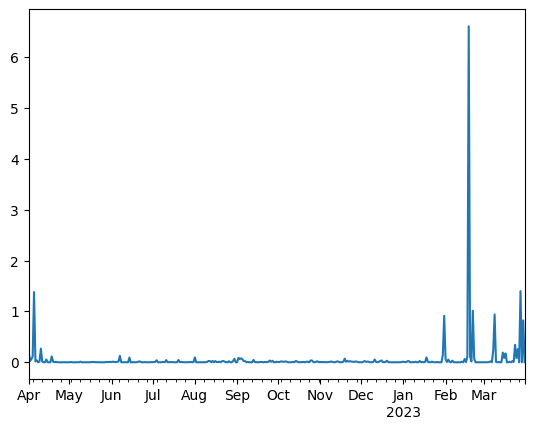

In [19]:
ds = open_dataset(
    'rc_trop_ls_MM/temp/rc_trop_ls_MM_d02km_d_2d_prcp_2022-2023.nc',
)
minas_rojas = find_lonlat(ds, "prcp", -90.3673, -0.618625)
# selected = ds.isel(west_east=minas_rojas[0], south_north=minas_rojas[1])
# selected = select_lonlat(ds, -90.3673, -0.618625)
minas_rojas.index = pd.DatetimeIndex(pd.date_range('2022-04-01','2023-03-31'))
minas_rojas.plot()

In [9]:
ds = open_dataset(
    'rc_trop_ls_d10km_d_2d_t2_2017.nc',
)
ds.t2.data = ds.t2.data - 273.15
ds["t2"] = ds.t2.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('t2')
ds.t2.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: b'/home/ben/data/GAR/rc_trop_ls_d10km_d_2d_t2_2017.nc'

In [11]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_ws10_2022.nc'
)
ds.ws10.data = ds.ws10.data
ds["ws10"] = ds.ws10.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('ws10')
ds.ws10.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: b'/home/ben/data/GAR/rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_ws10_2022.nc'

In [ ]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_v10_2022.nc',
    proj_string
)
ds["v10"] = ds.v10.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
plt.title('v10')
ds.v10.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

In [ ]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_prcp_2022.nc',
    proj_string
)
ds.prcp.data = ds.prcp.data
ds["prcp"] = ds.prcp.sum(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
ds.prcp.salem.quick_map(ax=ax, cmap=color_map)
plt.show()

/home/ben/.pyenv/versions/3.10.4/envs/darwin/lib/python3.10/site-packages/geopandas/geoseries.py:645: FutureWarning: the convert_dtype parameter is deprecated and will be removed in a future version.  Do ``ser.astype(object).apply()`` instead if you want ``convert_dtype=False``.
  result = super().apply(func, convert_dtype=convert_dtype, args=args, **kwargs)


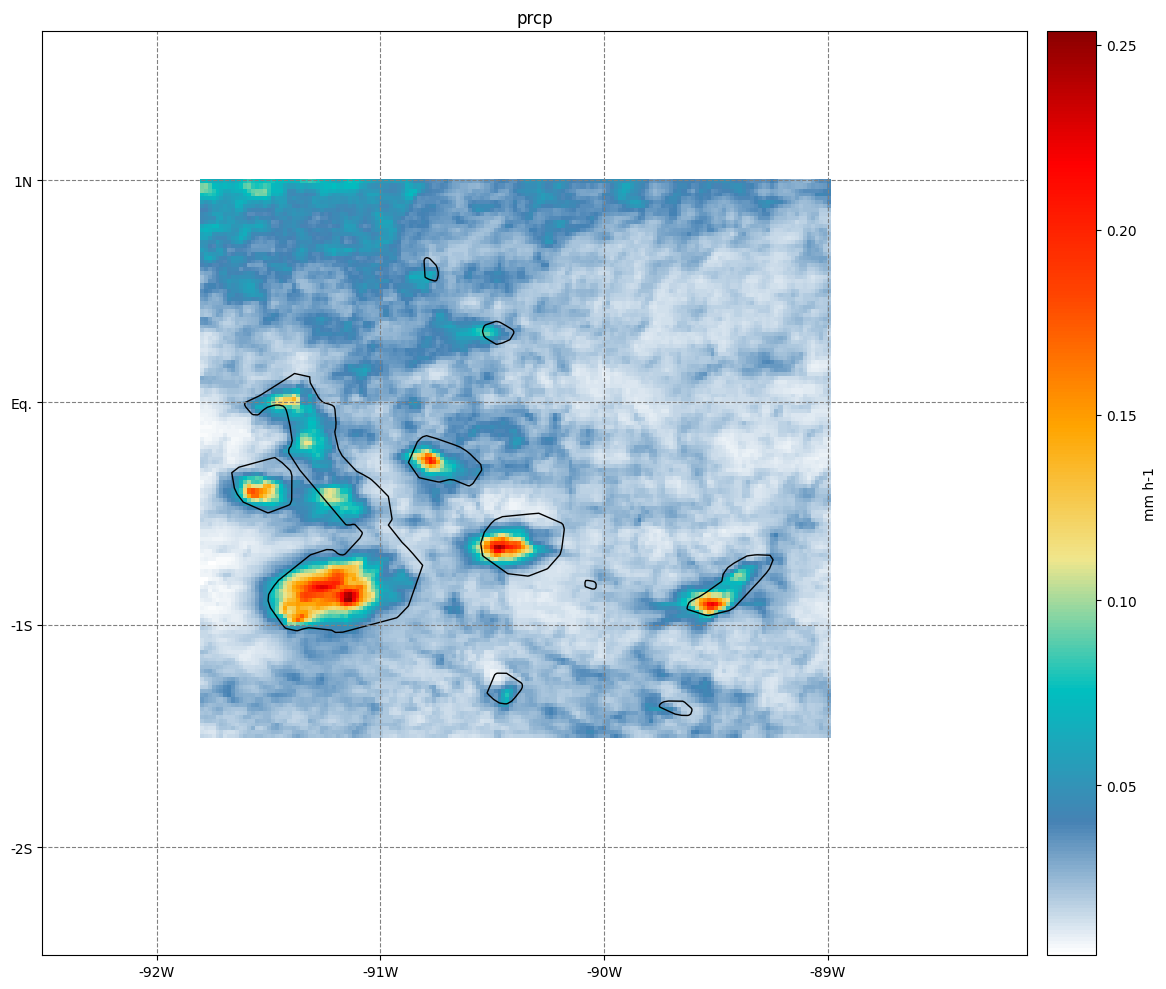

In [27]:

ds = open_dataset(
    'rc_trop_ls_MM/temp/rc_trop_ls_MM_d02km_h_2d_prcp_2022-2023.nc'
)
fig, ax = plt.subplots(figsize=(12, 10))
ds["prcp"] = ds.prcp.mean(dim='time', skipna=False, keep_attrs=True)
mask_all_touched = ds.prcp.salem.roi(shape=oceans, corners=((-91.8, -1.5), (-89, 1)), all_touched=True)
ds["prcp"].data = mask_all_touched
ds.prcp.salem.quick_map(ax=ax, cmap=color_map)
plt.tight_layout()
plt.show()

In [ ]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_q2_2022.nc',
    proj_string
)
ds["q2"] = ds.q2.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
mask_all_touched = ds.q2.salem.roi(shape=oceans, all_touched=True)
ds["q2"].data = mask_all_touched
ds.q2.salem.quick_map(ax=ax, cmap=color_map)

In [ ]:
ds = open_dataset(
    'rc_trop_ls/products/d02/d/2d/rc_trop_ls_d10km_d_2d_et_2022.nc',
    proj_string
)
ds["et"] = ds.et.mean(dim='time', skipna=True, keep_attrs=True)
fig, ax = plt.subplots(figsize=(12, 10))
mask_all_touched = ds.et.salem.roi(shape=oceans, all_touched=True)
ds["et"].data = mask_all_touched
ds.et.salem.quick_map(ax=ax, cmap=color_map)

In [12]:
l_prcp = open_dataset(
    'rc_trop_l/products/d02/d/2d/rc_test_large_tropical_d10km_d02_d_2d_prcp_2017.nc',
)

m_prcp = open_dataset(
    'rc_trop/products/d02/d/2d/rc_trop_d10km_d02_d_2d_prcp_2017.nc',
)

s_prcp = open_dataset(
    'rc_trop_s/products/d02/d/2d/rc_trop_s_d10km_d02_d_2d_prcp_2017.nc',
)
ls_prcp = open_dataset(
    'rc_trop_ls_d10km_d_2d_prcp_2017.nc',
)
ls43_prcp = open_dataset(
    'rc_trop_ls_vert43_d10km_d_2d_prcp_2017.nc'
)

FileNotFoundError: [Errno 2] No such file or directory: b'/home/ben/data/GAR/rc_trop_l/products/d02/d/2d/rc_test_large_tropical_d10km_d02_d_2d_prcp_2017.nc'

NameError: name 'l_prcp' is not defined

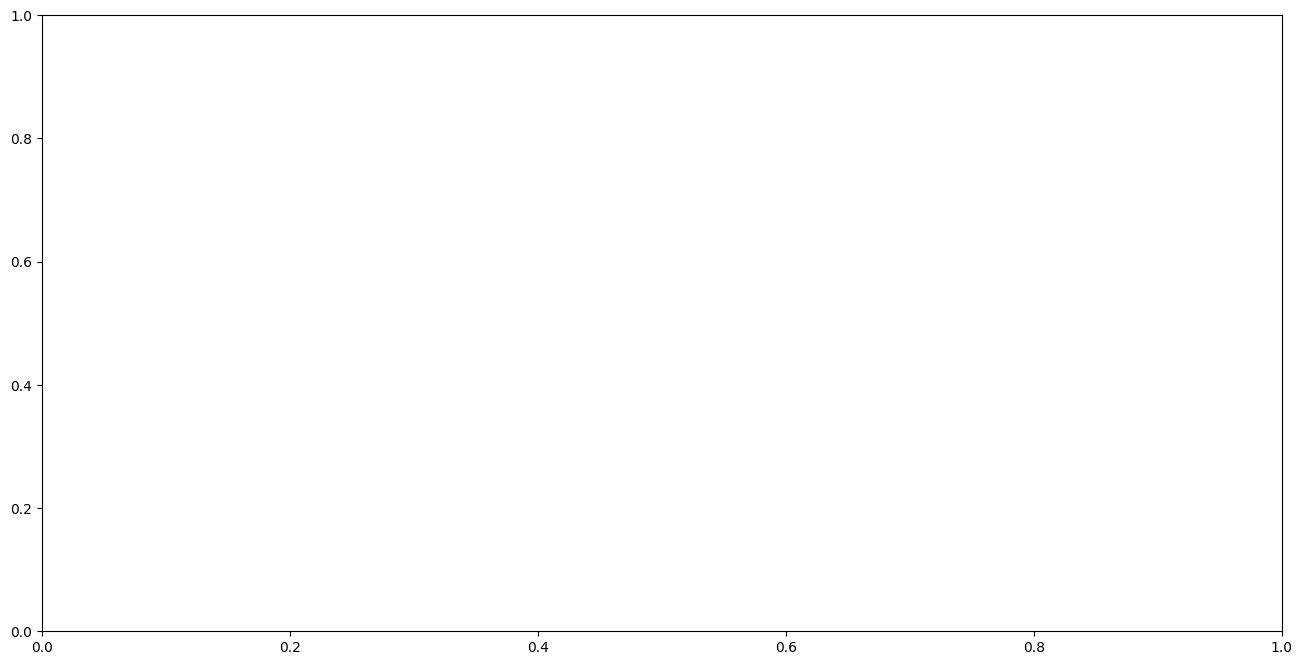

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
mask_all_touched = l_prcp.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.mean(axis=(1,2)).cumsum().plot(ax=ax, label="L  - 43 vertical levels")
# l_prcp.prcp.sum(axis=(1,2)).cumsum().plot(ax=ax, label="large prcp")
mask_all_touched = m_prcp.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.mean(axis=(1,2)).cumsum().plot(ax=ax, label="M - 43 vertical levels")
# m_prcp.prcp.sum(axis=(1,2)).cumsum().plot(ax=ax, label="medium prcp")
mask_all_touched = s_prcp.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.mean(axis=(1,2)).cumsum().plot(ax=ax, label="S - 43 vertical levels")
# s_prcp.prcp.sum(axis=(1,2)).cumsum().plot(ax=ax, label="small prcp")
mask_all_touched = ls43_prcp.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.mean(axis=(1,2)).cumsum().plot(ax=ax, label="LS - 43 vertical levels")
mask_all_touched = ls_prcp.prcp.salem.roi(shape=oceans, all_touched=True)
mask_all_touched.mean(axis=(1,2)).cumsum().plot(ax=ax, label="LS - 28 vertical levels")
#
plt.ylabel('average precipitation per grid point im mm')
ax.legend()
plt.savefig("domain_sizes_prcp_land.png")
plt.show()

In [14]:
# plot land cover static data
lu_index = open_dataset(
    'rc_trop_l/products/d10km_d02/static/rc_test_large_tropical_d10km_d02_static_lu_index.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
lu_index.lu_index.data[lu_index.lu_index.data == 16] = np.nan

lu_index.lu_index.plot(cmap='Set1', figsize=(12,10))
plt.savefig('lu_index.png')

TypeError: open_dataset() takes 1 positional argument but 2 were given

In [15]:
v10_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m = v10_m.v10.salem.subset(grid=v10_s.v10.salem.grid)
v10_l = v10_l.v10.salem.subset(grid=v10_s.v10.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
v10_s.v10.salem.quick_map(ax=ax3, cmap='RdBu', vmin=-2, vmax=5.5)
v10_m.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2, vmax=5.5)
v10_l.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2, vmax=5.5)
plt.tight_layout()
plt.savefig('v10_domains.png')
plt.show()

TypeError: open_dataset() takes 1 positional argument but 2 were given

In [16]:
v10_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_v10_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
v10_l_s.v10.data = (v10_l.data - v10_s.v10.data)
v10_m_s.v10.data = (v10_m.data - v10_s.v10.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
v10_l_s.v10.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2.7, vmax=2.7)
v10_m_s.v10.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2.7, vmax=2.7)
plt.tight_layout()
plt.savefig('v10_compare.png')
plt.show()

TypeError: open_dataset() takes 1 positional argument but 2 were given

In [ ]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='RdBu', vmin=-5.5, vmax=3, )
ws_m.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-5.5, vmax=3)
ws_l.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-5.5, vmax=3)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

In [ ]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='RdBu', vmin=-2.7, vmax=2.7)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='RdBu', vmin=-2.7, vmax=2.7)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()

In [ ]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/2d/rc_test_large_tropical_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/2d/rc_trop_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l.ws.data = ws_l.ws.data * 24 * 365
ws_m.ws.data = ws_m.ws.data * 24 * 365
ws_s.ws.data = ws_s.ws.data * 24 * 365
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365, )
ws_m.salem.quick_map(ax=ax2, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365)
ws_l.salem.quick_map(ax=ax1, cmap='Blues', vmin=0, vmax=0.7 * 24 * 365)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

In [ ]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/2d/rc_trop_s_d10km_d02_y_2d_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='bwr', vmin=-.21 * 24 * 365, vmax=.21 * 24 * 365)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='bwr', vmin=-.21 * 24 * 365, vmax=.21 * 24 * 365)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()

In [ ]:
ws_l.sel(pressure=500)

In [ ]:
ws_l = open_dataset(
    'rc_trop_l/products/d10km_d02/y/3d_press/rc_trop_l_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m = open_dataset(
    'rc_trop/products/d10km_d02/y/3d_press/rc_trop_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.3 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_l = ws_l.sel(pressure=800)
ws_m = ws_m.sel(pressure=800)
ws_s = ws_s.sel(pressure=800)
ws_m = ws_m.ws.salem.subset(grid=ws_s.ws.salem.grid)
ws_l = ws_l.ws.salem.subset(grid=ws_s.ws.salem.grid)
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(18, 12))
plt.tight_layout()
ws_s.ws.salem.quick_map(ax=ax3, cmap='viridis', vmin = 4, vmax = 7.4)
ws_m.salem.quick_map(ax=ax2, cmap='viridis', vmin = 4, vmax = 7.4)
ws_l.salem.quick_map(ax=ax1, cmap='viridis', vmin = 4, vmax = 7.4)
plt.tight_layout()
plt.savefig('ws_domains.png')
plt.show()

In [ ]:
ws_l_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)
ws_m_s = open_dataset(
    'rc_trop_s/products/d02/y/3d_press/rc_trop_s_d10km_d02_y_3d_press_ws_2017.nc',
    '+proj=merc +lat_0=2 +lon_0=-90.22 +k=1 +x_0=0 +y_0=00 +ellps=WGS84 +datum=WGS84 +units=m +no_defs'
)

ws_l_s = ws_l_s.sel(pressure=800)
ws_m_s = ws_m_s.sel(pressure=800)

ws_l_s.ws.data = (ws_l.data - ws_s.ws.data)
ws_m_s.ws.data = (ws_m.data - ws_s.ws.data)
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(18, 12))
ws_l_s.ws.salem.quick_map(ax=ax1, cmap='bwr', vmin=-1, vmax=1)
ws_m_s.ws.salem.quick_map(ax=ax2, cmap='bwr', vmin=-1, vmax=1)
plt.tight_layout()
plt.savefig('ws_compare.png')
plt.show()

In [ ]:
import os 
path_ = os.path.abspath(".")
type(path_) == str